In [1]:
import numpy as np
from scipy import ndimage
from astropy.io import fits
import os
import astroalign as aa
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.background import Background2D, MedianBackground
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
import matplotlib.pyplot as plt
from skyfield.api import load, wgs84

# Master Bias

In [2]:
#Master Bias


date = '110128'
bias = []
for subdir, dir, files in os.walk(f'/net/dataserver3/data/users/sterrenwacht/images/{date}/STL-6303E/i'):#for loop to iterate over all fits files
    for filename in files: #loop over only the files
        # open the bias files and append them to a master bias
        hdulist = fits.open(f"/net/dataserver3/data/users/sterrenwacht/images/{date}/STL-6303E/i/{filename}")# open the bias files and appen
        hdr = hdulist[0].header #header of bias files 
        if hdr['IMAGETYP'] == 'Bias Frame':
            data = hdulist[0].data  #raw bias files
            bias.append(data)
            
#stacks the bias arrays along the z axis and take the median
master_bias = np.median(np.stack(bias, axis=0), axis=0)

#write the masterbias to disk
hdu = fits.PrimaryHDU(master_bias)
hdul = fits.HDUList([hdu])
hdul.writeto(f'/Users/users/tonckens/BULK/LDSThesis/master_bias.fits', output_verify='ignore', overwrite=True)



# Master Dark

In [3]:
#Master Dark
dark = []
#open the masterbias
master_bias = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/master_bias.fits")[0].data

for subdir, dir, files in os.walk(f'/net/dataserver3/data/users/sterrenwacht/images/{date}/STL-6303E/i'):#for loop to iterate over all fits files
    for filename in files: #loop over only the files
        hdulist = fits.open(f"/net/dataserver3/data/users/sterrenwacht/images/{date}/STL-6303E/i/{filename}")# open the dARK files and appen
        hdr = hdulist[0].header
        if hdr['IMAGETYP'] == 'Dark Frame':#condition to only allow dark files in the next step
            data = hdulist[0].data  #raw dark files
            #subtract the master bias and divide by exposure time
            data = (data-master_bias)/300
            dark.append(data)
            
#stack the dark frames and take the median
master_dark = np.median(np.stack(dark, axis=0), axis=0)

#write masterdark to disk
hdu = fits.PrimaryHDU(master_dark)
hdul = fits.HDUList([hdu])
hdul.writeto(f'/Users/users/tonckens/BULK/LDSThesis/master_dark.fits', output_verify='ignore', overwrite=True)
            


# Master Flat Field

In [4]:
#imports the master and dark bias frames made before in order to create the Flatfield
hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/master_bias.fits")
master_bias = hdulist[0].data

hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/master_dark.fits")
master_dark = hdulist[0].data

flatR = []
flatB = []
flatV = []
for subdir, dir, files in os.walk(f'/net/dataserver3/data/users/sterrenwacht/images/{date}/STL-6303E/i'): #for loop to iterate over all fits files
    for filename in files:
        hdulist = fits.open(f"/net/dataserver3/data/users/sterrenwacht/images/{date}/STL-6303E/i/{filename}")
        hdr = hdulist[0].header
        if hdr['IMAGETYP'] == 'Flat Field':
            data = hdulist[0].data
            data = data - master_bias
            data = data - master_dark*hdr['EXPTIME'] #scales the master dark to the exposure time of the flatfield frame
            data = data/np.median(data)
            if hdr['FILTER'] == 'R':
                flatR.append(data)
            if hdr['FILTER'] == 'B':
                flatB.append(data)
            if hdr['FILTER'] == 'V':
                flatV.append(data)
                

#check if there are flatfields made
if len(flatR) !=0:
    master_flatR = np.median(np.stack(flatR,axis=0), axis=0) #take the median along the images
    #saves the flatfield in directory
    hdu = fits.PrimaryHDU(master_flatR)
    hdul = fits.HDUList([hdu])
    hdul.writeto(f'/Users/users/tonckens/BULK/LDSThesis/master_flatR.fits', output_verify='ignore', overwrite=True)
    print("The Flatfield has been saved as a fits file in the directory.")
if len(flatB) !=0:
    master_flatB = np.median(np.stack(flatB,axis=0), axis=0) #take the median along the images
    #saves the flatfield in directory
    hdu = fits.PrimaryHDU(master_flatB)
    hdul = fits.HDUList([hdu])
    hdul.writeto(f'/Users/users/tonckens/BULK/LDSThesis/master_flatB.fits', output_verify='ignore', overwrite=True)
    print("The Flatfield has been saved as a fits file in the directory.")
if len(flatV) !=0:
    master_flatV = np.median(np.stack(flatV,axis=0), axis=0) #take the median along the images
    #saves the flatfield in directory
    hdu = fits.PrimaryHDU(master_flatV)
    hdul = fits.HDUList([hdu])
    hdul.writeto(f'/Users/users/tonckens/BULK/LDSThesis/master_flatV.fits', output_verify='ignore', overwrite=True)
    print("The Flatfield has been saved as a fits file in the directory.")

The Flatfield has been saved as a fits file in the directory.
The Flatfield has been saved as a fits file in the directory.
The Flatfield has been saved as a fits file in the directory.


# Noise reduction on the RGB frames

In [5]:
#open the dark and bias files
hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/master_bias.fits")
master_bias = hdulist[0].data

hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/master_dark.fits")
master_dark = hdulist[0].data

if len(flatR) != 0:
    hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/master_flatR.fits")
    master_flatR = hdulist[0].data
if len(flatB) != 0:
    hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/master_flatB.fits")
    master_flatB = hdulist[0].data
if len(flatV) != 0:
    hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/master_flatV.fits")
    master_flatV = hdulist[0].data

#define needed parameters found on the photutils site
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()

for subdir, dir, files in os.walk(f'/net/dataserver3/data/users/sterrenwacht/images/{date}/STL-6303E/i'): #for loop to iterate over all fits files
    for filename in sorted(files):
        #opening data

        hdulist = fits.open(f"/net/dataserver3/data/users/sterrenwacht/images/{date}/STL-6303E/i/{filename}")
        hdr = hdulist[0].header
        if hdr['FILTER '] == 'R' and hdr['IMAGETYP'] == 'Light Frame':
            
            data = hdulist[0].data
            #bias, dark, flat and background reduction
            data = data - master_bias 
            data = data - master_dark*hdr['EXPTIME']
            if len(flatR) != 0:
                data = data/master_flatR
            bkg = Background2D(data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator) # create the background estimation
            data = data-bkg.background
            #saving the data
            hdu = fits.PrimaryHDU(data,header=hdr)
            hdul = fits.HDUList([hdu])
            hdul.writeto(f"/Users/users/tonckens/BULK/LDSThesis/{date}/red/{filename}", output_verify='ignore', overwrite=True) #saves the reduced images in the same directory as notebook
        if hdr['FILTER '] == 'B' and hdr['IMAGETYP'] == 'Light Frame':
            #opening data
            
            hdr = hdulist[0].header
            data = hdulist[0].data
            #bias, dark, flat and background reduction
            data = data - master_bias 
            data = data - master_dark*hdr['EXPTIME']
            if len(flatB) != 0:
                data = data/master_flatB
            bkg = Background2D(data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator) # create the background estimation
            data = data-bkg.background
            #saving the data
            hdu = fits.PrimaryHDU(data,header=hdr)
            hdul = fits.HDUList([hdu])
            hdul.writeto(f"/Users/users/tonckens/BULK/LDSThesis/{date}/blue/{filename}", output_verify='ignore', overwrite=True) #saves the reduced images in the same directory as notebook
        if hdr['FILTER '] == 'V' and hdr['IMAGETYP'] == 'Light Frame':
            #opening data
            hdr = hdulist[0].header
            data = hdulist[0].data
            #bias, dark, flat and background reduction
            data = data - master_bias 
            data = data - master_dark*hdr['EXPTIME']
            if len(flatV) != 0:
                data = data/master_flatV
            bkg = Background2D(data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator) # create the background estimation
            data = data-bkg.background
            #saving the data
            hdu = fits.PrimaryHDU(data,header=hdr)
            hdul = fits.HDUList([hdu])
            hdul.writeto(f"/Users/users/tonckens/BULK/LDSThesis/{date}/green/{filename}", output_verify='ignore', overwrite=True) #saves the reduced images in the same directory as notebook
        
print("All the images have been noise reduced and are now saved in the directory as fits files.")

All the images have been noise reduced and are now saved in the directory as fits files.


# align the images and normalize the flux to a single frame

In [6]:
#lists for easy managment
red = []
alignedlist = []
red_name = np.array([])
red_hdr = []
alignedlistred = []

green = []
green_name = np.array([])
green_hdr = []
alignedlistgreen = []

blue = []
blue_name = np.array([])
blue_hdr = []
alignedlistblue = []

#allign the red images
for subdir, dir, files in os.walk(f'/Users/users/tonckens/BULK/LDSThesis/{date}/red'): #for loop to iterate over all fits files
    for filename in sorted(files):
        hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/{date}/red/{filename}")
        hdr = hdulist[0].header
        data = hdulist[0].data
        red.append(data)
        red_name = np.append(red_name,filename)
        red_hdr.append(hdr)
        

red = np.stack(red)

#image aligner and flux normalizer to a single frame
for t in range(len(red)):
    #aligns every image to reference image number 0
    aligned, footprint = aa.register(red[t], red[0])
    
    #source extractor for target flux
    mean, median, std = sigma_clipped_stats(red[0],sigma=3.0)
    daofind = DAOStarFinder(fwhm=3.0,threshold=5.*std)
    sources_source = daofind(red[0])
    
    #source extractor for source flux
    mean, median, std = sigma_clipped_stats(aligned,sigma=3.0)
    daofind = DAOStarFinder(fwhm=3.0,threshold=5.*std)
    sources_target = daofind(aligned)
    
    #normalize source to target by a factor of peak intensity of the same star
    #print(sources_target['peak'][np.argmax(sources_target['xcentroid'])],sources_source['peak'][np.argmax(sources_source['xcentroid'])])
    factor = sources_source['peak'][np.argmax(sources_source['xcentroid'])]/sources_target['peak'][np.argmax(sources_target['xcentroid'])]
    aligned = aligned*factor
    sources_target2 = daofind(aligned)
    #print(sources_target2['peak'][np.argmax(sources_target2['xcentroid'])])
    
    #save images
    alignedlistred.append(aligned)
    hdu = fits.PrimaryHDU(aligned,red_hdr[t])
    hdul = fits.HDUList([hdu])
    hdul.writeto(f"/Users/users/tonckens/BULK/LDSThesis/{date}/red/{red_name[t]}", output_verify='ignore', overwrite=True) 

hdu = fits.PrimaryHDU(np.stack(alignedlistred))
hdul = fits.HDUList([hdu])
hdul.writeto(f"/Users/users/tonckens/BULK/LDSThesis/{date}/redaligned.fits", output_verify='ignore', overwrite=True)    
    
    
        
#allign the blue images
for subdir, dir, files in os.walk(f'/Users/users/tonckens/BULK/LDSThesis/{date}/blue'): #for loop to iterate over all fits files
    for filename in sorted(files):
        hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/{date}/blue/{filename}")
        hdr = hdulist[0].header
        data = hdulist[0].data
        blue.append(data)
        blue_name = np.append(blue_name,filename)
        blue_hdr.append(hdr)

if len(blue) != 0:
    blue = np.stack(blue)        

#image aligner and flux normalizer to a single frame
    for t in range(len(blue)):
        aligned, footprint = aa.register(blue[t], blue[0])#aligns every image to reference image number 0
    
    #source extractor for target flux
        mean, median, std = sigma_clipped_stats(blue[0],sigma=3.0)
        daofind = DAOStarFinder(fwhm=3.0,threshold=5.*std)
        sources_source = daofind(blue[0])
    
    #apply to all images by a factor
        mean, median, std = sigma_clipped_stats(aligned,sigma=3.0)
        daofind = DAOStarFinder(fwhm=3.0,threshold=5.*std)
        sources_target = daofind(aligned)
    
    #normalize source to target by a factor of peak intensity of the same star
        factor = sources_source['peak'][np.argmax(sources_source['xcentroid'])]/sources_target['peak'][np.argmax(sources_target['xcentroid'])]
        aligned = aligned*factor

    
    #save images
        alignedlistblue.append(aligned)
        hdu = fits.PrimaryHDU(aligned,blue_hdr[t])
        hdul = fits.HDUList([hdu])
        hdul.writeto(f"/Users/users/tonckens/BULK/LDSThesis/{date}/blue/{blue_name[t]}", output_verify='ignore', overwrite=True) 
    

    hdu = fits.PrimaryHDU(np.stack(alignedlistblue))
    hdul = fits.HDUList([hdu])
    hdul.writeto(f"/Users/users/tonckens/BULK/LDSThesis/{date}/bluealigned.fits", output_verify='ignore', overwrite=True)    
    
#allign the green images
for subdir, dir, files in os.walk(f'/Users/users/tonckens/BULK/LDSThesis/{date}/green'): #for loop to iterate over all fits files
    for filename in sorted(files):
        hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/{date}/green/{filename}")
        hdr = hdulist[0].header
        data = hdulist[0].data
        green.append(data)
        green_name = np.append(green_name,filename)
        green_hdr.append(hdr)

        
green = np.stack(green)


for t in range(len(green)):
    aligned, footprint = aa.register(green[t], green[0])#aligns every image to reference image number 0
    
    #source extractor for target flux
    mean, median, std = sigma_clipped_stats(green[0],sigma=3.0)
    daofind = DAOStarFinder(fwhm=3.0,threshold=5.*std)
    sources_source = daofind(green[0])
    
    #apply to all images by a factor
    mean, median, std = sigma_clipped_stats(aligned,sigma=3.0)
    daofind = DAOStarFinder(fwhm=3.0,threshold=5.*std)
    
    #normalize source to target by a factor of peak intensity of the same star
    sources_target = daofind(aligned)
    factor = sources_source['peak'][np.argmax(sources_source['xcentroid'])]/sources_target['peak'][np.argmax(sources_target['xcentroid'])]
    aligned = aligned*factor
    
    #save images
    hdu = fits.PrimaryHDU(aligned,green_hdr[t])
    hdul = fits.HDUList([hdu])
    alignedlistgreen.append(aligned)
    hdul.writeto(f"/Users/users/tonckens/BULK/LDSThesis/{date}/green/{green_name[t]}", output_verify='ignore', overwrite=True) 


hdu = fits.PrimaryHDU(np.stack(alignedlistgreen))
hdul = fits.HDUList([hdu])
hdul.writeto(f"/Users/users/tonckens/BULK/LDSThesis/{date}/greenaligned.fits", output_verify='ignore', overwrite=True)  



# Isolating the satellite trail

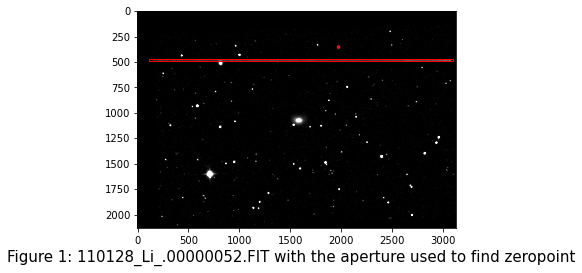

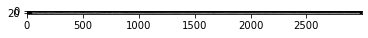

Figure 2: The box, from previous image enclosing the satellite trail, plotted horizontally 
 

Effective V band magnitude satellite: 17.982220382001387+/- 0.5689930048425822
Apparent V band magnitude satellite: 5.408783389508606+/- 0.5689930048425822
Absolute (1000m) V band magnitude satellite: 4.5330225475519095+/- 0.5689930048425822
V band magnitude satellite at perigee: 3.9501940159669564+/- 0.5689930048425822


In [8]:
hdulist = fits.open(f"/Users/users/tonckens/BULK/LDSThesis/{date}/greenaligned.fits") #open the file with a satellite track
dat = hdulist[0].data
track = dat[16] # image with the track
frame = np.median(dat,axis=0)#median of all images
track_iso = track-frame
#make the apeture for star
x_star = 1977
y_star = 354
r_star = 11
aperture = CircularAperture((x_star,y_star), r=r_star) #define the circle
circle1 = plt.Circle((x_star,y_star), r_star, color='r')

#make the box for the trail
xy = (110,470)
width = 25
length = 2995
rotation = 1.68
track_iso = ndimage.rotate(track_iso,rotation) #correct rotation
box = plt.Rectangle(xy, length, width, linewidth=1, edgecolor='r', facecolor='none')
IMAGE = (track_iso[xy[1]:xy[1]+width,xy[0]:xy[0]+length])




#plotting for checking
ax = plt.gca()
ax.cla()
ax.add_patch(box)
ax.add_patch(circle1)
plt.imshow(ndimage.rotate(track,rotation),cmap='gray', vmin=0, vmax=255)
txt = 'Figure 1: 110128_Li_.00000052.FIT with the aperture used to find zeropoint' #caption for the image
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=15)
plt.show()


#plotting the isolated trail
plt.imshow(IMAGE,cmap='gray', vmin=0, vmax=255)
plt.show()
print("Figure 2: The box, from previous image enclosing the satellite trail, plotted horizontally \n \n")

#find the counts and zeropoint for the star for magnitude determination
magnitude_star = 11.98 # star TYC 4544-1790-1
counts_star = ((aperture_photometry(ndimage.rotate(frame,rotation), aperture))['aperture_sum'])/red_hdr[0]['exptime']
zeropoint = magnitude_star + 2.5*np.log10(int(counts_star)) #determine the zeropoint


#find the maximum counts for the satellite trail  
counts = np.array([np.sum(IMAGE[:,i]) for i in range(length)])
counts = counts/red_hdr[0]['exptime']
dif = np.max(counts)-np.mean(counts)

#find the magnitudes of the counts
magnitude_sat_eff = -2.5*np.log10(np.mean(counts))+zeropoint#calculate the magnitudes of the asteroid
magnitude_sat_eff_max = -2.5*np.log10(np.max(counts))+zeropoint#calculate the magnitudes of the asteroid
err = np.abs(magnitude_sat_eff_max-magnitude_sat_eff)

#magnitude calculations
period = 6420
angular_velocity = (360*3600)/period
D = 1496.76
t_exp = 300
r = 0.566
perigee = 764.6
magnitude_sat_apparent = magnitude_sat_eff + 2.5*np.log10(r/(angular_velocity*t_exp))
magnitude_sat_abs = magnitude_sat_apparent - 5*np.log10(D/1000)
magnitude_sat_perigee = magnitude_sat_apparent - 5*np.log10(D/perigee)

print(f"Effective V band magnitude satellite: {magnitude_sat_eff}+/- {err}")
print(f"Apparent V band magnitude satellite: {magnitude_sat_apparent}+/- {err}")
print(f"Absolute (1000m) V band magnitude satellite: {magnitude_sat_abs}+/- {err}")
print(f"V band magnitude satellite at perigee: {magnitude_sat_perigee}+/- {err}")


